## Import dependencies

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import random

print(tf.__version__)

2.8.0


## Download and explore the MNIST dataset
The MNIST database contains 60,000 training images and 10,000 testing images of handwritten digits. This dataset will be used to train digit classification model.

Each image in the MNIST dataset is a 28x28 grayscale image containing a digit from 0 to 9, and a label identifying which digit is in the image.
![MNIST sample](https://github.com/khanhlvg/DigitClassifier/raw/master/images/mnist.png)

In [2]:
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images / 255.0
test_images = test_images / 255.0
print('Pixels are normalized')

Pixels are normalized


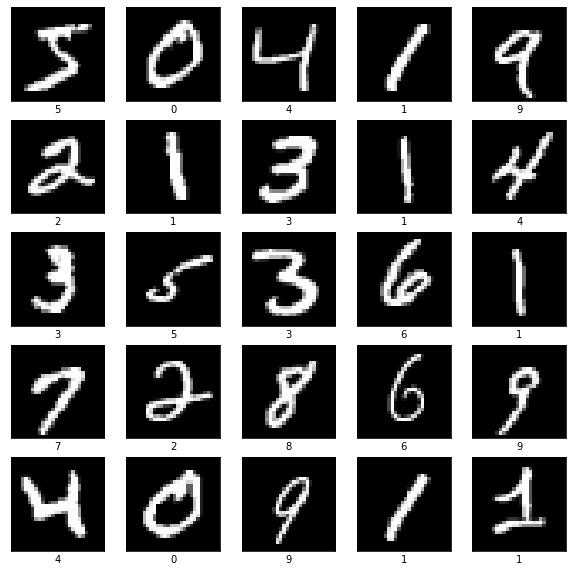

In [ ]:
# Show the first 25 images in the training dataset.
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(train_images[i], cmap=plt.cm.gray)
  plt.xlabel(train_labels[i])
plt.show()

## Train a TensorFlow model to classify digit images

Next, use Keras API to build a TensorFlow model and train it on the MNIST "train" dataset. After training, the model will be able to classify the digit images.

The model takes **a 28px x 28px grayscale image** as an input, and outputs **a float array of length 10** representing the probability of the image being a digit from 0 to 9.

Here a simple convolutional neural network is used. This is a common technique in computer vision.

In [ ]:
# Define the model architecture
model = keras.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28)),
  keras.layers.Reshape(target_shape=(28, 28, 1)),
  keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
  keras.layers.MaxPooling2D(pool_size=(2, 2)),
  keras.layers.Dropout(0.25),
  keras.layers.Flatten(),
  keras.layers.Dense(10)
])

# Define how to train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the digit classification model
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 22s 7ms/step - loss: 0.1377 - accuracy: 0.9578
Epoch 2/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0534 - accuracy: 0.9837
Epoch 3/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0404 - accuracy: 0.9871
Epoch 4/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0315 - accuracy: 0.9901
Epoch 5/5
1875/1875 [==============================] - 12s 6ms/step - loss: 0.0252 - accuracy: 0.9919


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                        

## Evaluate the model
Next, run digit classification model against "test" dataset that the model has not seen during its training process to confirm that the model did not just remember the digits it saw but also generalize well to new images.

In [ ]:
# Evaluate the model using all images in the test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 2s 6ms/step - loss: 0.0419 - accuracy: 0.9872
Test accuracy: 0.9872000217437744


Although model is relatively simple, it is able to achieve good accuracy around 98% on new images that the model has never seen before. Let's visualize

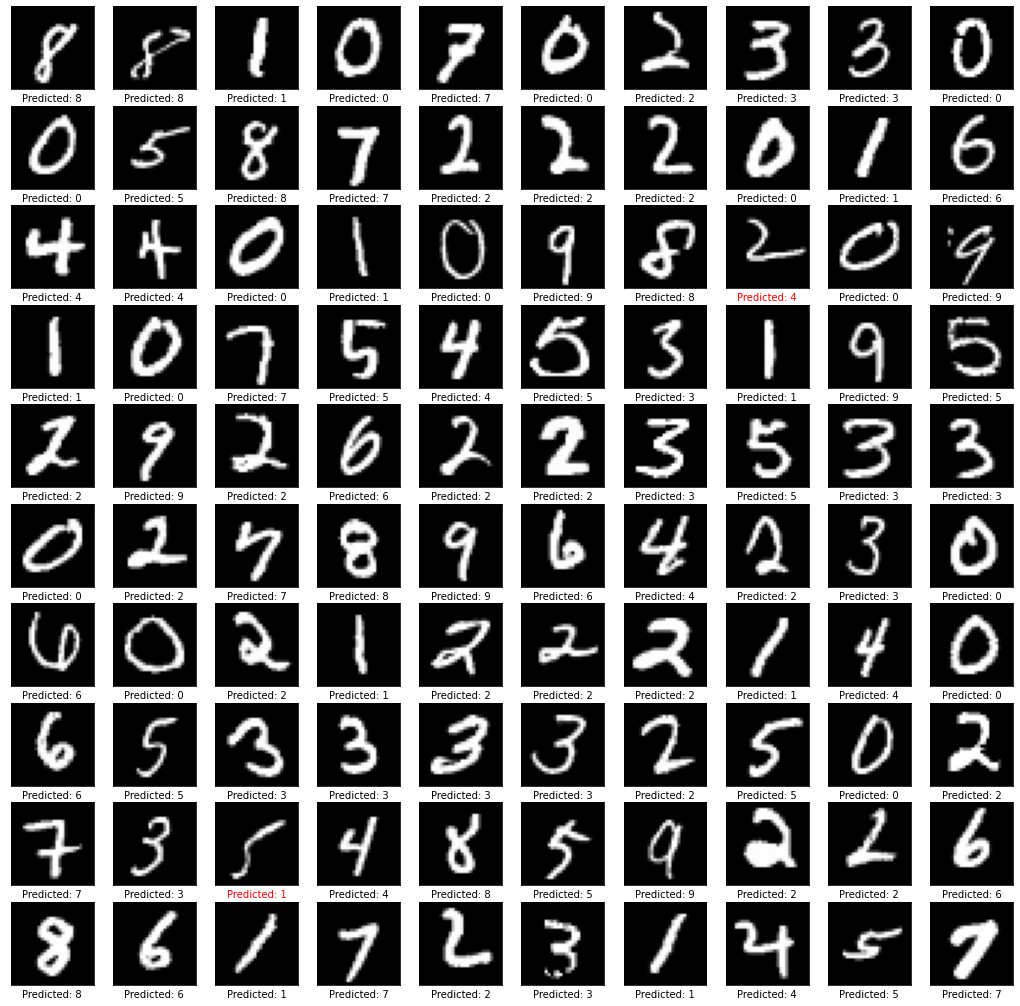

In [ ]:
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

predictions = model.predict(test_images)
prediction_digits = np.argmax(predictions, axis=1)
plt.figure(figsize=(18, 18))
for i in range(100):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image_index = random.randint(0, len(prediction_digits))
  plt.imshow(test_images[image_index], cmap=plt.cm.gray)
  ax.xaxis.label.set_color(get_label_color(prediction_digits[image_index],\
                                           test_labels[image_index]))
  plt.xlabel('Predicted: %d' % prediction_digits[image_index])
plt.show()

## Download the model

In [ ]:
# Save the model to file to the Downloads directory
model.save('mnist.h5')
# Download the digit classification model
from google.colab import files
files.download('mnist.h5')

print('`mnist.h5` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`mnist.h5` has been downloaded


## Convert the Keras model to TensorFlow Lite

Now as trained digit classifer model is exists, it is needed to convert it to TensorFlow Lite format for mobile deployment.

In [ ]:
# Convert Keras model to TF Lite format.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

INFO:tensorflow:Assets written to: /tmp/tmpondlw7yg/assets


Float model size = 436KBs.


As the model will be deployed on a mobile device, the model is needed to be as small and as fast as possible. **Quantization** is a common technique often used in on-device machine learning to shrink ML models. Here is used a 8-bit number to approximate 32-bit weights, which in turn shrinks the model size by a factor of 4.

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

INFO:tensorflow:Assets written to: /tmp/tmpki5uqqgo/assets


INFO:tensorflow:Assets written to: /tmp/tmpki5uqqgo/assets


Quantized model size = 114KBs,
which is about 26% of the float model size.


## Evaluate the TensorFlow Lite model

By using quantization, a bit of accuracy is often traded off for the benefit of having a significantly smaller model. Here the accuracy drop of the quantized model is calculated.

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_tflite_model(tflite_model):
  # Initialize TFLite interpreter using the model.
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()
  input_tensor_index = interpreter.get_input_details()[0]["index"]
  output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_tensor_index, test_image)

    # Run inference.
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  return accuracy

# Evaluate the TF Lite float model. You'll find that its accurary is identical
# to the original TF (Keras) model because they are essentially the same model
# stored in different format.
float_accuracy = evaluate_tflite_model(tflite_float_model)
print('Float model accuracy = %.4f' % float_accuracy)

# Evalualte the TF Lite quantized model.
# Don't be surprised if you see quantized model accuracy is higher than
# the original float model. It happens sometimes :)
quantized_accuracy = evaluate_tflite_model(tflite_quantized_model)
print('Quantized model accuracy = %.4f' % quantized_accuracy)
print('Accuracy drop = %.4f' % (float_accuracy - quantized_accuracy))


Float model accuracy = 0.9880
Quantized model accuracy = 0.9878
Accuracy drop = 0.0002


## Download the TensorFlow Lite model

Now it is needed to get the model and integrate it into an Android app.

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('mnist.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

# Download the digit classification model
from google.colab import files
files.download('mnist.tflite')

print('`mnist.tflite` has been downloaded')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

`mnist.tflite` has been downloaded
